
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # we can try different initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing and Data augmentation**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #AlexNet takes 224x224 input image
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(), #scales values to [0-1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #AlexNet takes 224x224 input image
    transforms.ToTensor(), #scales values to [0-1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech #(new dataset with __init__, __len__, __get_item__ not needed) 
import sklearn.model_selection as ms
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes, val_indexes = ms.train_test_split(list(range(train_dataset.__len__())), train_size=0.5)  # split the indices for your train and validation (on train set) split
#cross-validation is too much expensive, so we set a validation set at the beginning

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 3048
Valid Dataset: 3048
Test Dataset: 3049


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



**Create Network**

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 21, padding=10)
        self.pool1 = nn.MaxPool2d(3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(6, 12, 21, padding=10)
        self.pool2 = nn.MaxPool2d(5, padding=2, stride = 1)
        self.conv3 = nn.Conv2d(12, 36, 21, padding=10)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = nn.Conv2d(12, 12, 21, padding=10)
        self.fc1 = nn.Linear(36*56*56, 1024)
        self.fc2 = nn.Linear(1024, 500)
        self.fc3 = nn.Linear(500, 200)
        self.fc4 = nn.Linear(200, NUM_CLASSES)

    def forward(self, inputs):

        x = self.conv1(inputs)

        x = self.pool1(F.relu(x))

        x = self.conv2(x)

        x = self.pool2(F.relu(x))

        x = self.conv4(x)

        x = self.pool3(F.relu(x))

        x = self.conv3(x)

        x = self.pool3(F.relu(x))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

    


**Prepare Network**

In [15]:
net = NN() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

#we use mode.classifier[6] because AlexNet has 12 layers, first block is model.features (conv layers) and the second is model.classifier (linear layers)

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [19]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# Struttura di net.classifier in AlexNet:
#classifier = nn.Sequential(
 #   nn.Dropout(),              # [0] 
 #   nn.Linear(256 * 6 * 6, 4096),  # [1] primo FC layer
 #   nn.ReLU(inplace=True),     # [2]
 #   nn.Dropout(),              # [3]
 #   nn.Linear(4096, 4096),     # [4] secondo FC layer  
  #  nn.ReLU(inplace=True),     # [5]
   # nn.Linear(4096, 1000)      # [6] ULTIMO layer: 4096 → 1000 classi ImageNet
#)
# e.g.: parameters of the convolutional layers: net.features.parameters()
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY) #weight decay is L2 optimization 

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) #every step epochs (step_size) we decrease LR by gamma

**Train**

In [20]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
train_loss = []
val_loss = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  epoch_loss = 0
  n_batches = 0
  net.train() # Sets module in training mode

  # Iterate over the dataset
  for images, labels in train_dataloader: #loads batches --> list of tuples (image, label)
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    n_batches +=1

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images) #vettore di logits per ogni immagine nel batch
    # DEBUG: Controlla labels e outputs

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels) #media loss per immagini nel batch
    epoch_loss += loss.item()
    
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  
  train_loss.append(epoch_loss/n_batches)
  
  net.eval()
  val_loss_cumul = 0
  n_batches_val = 0


  with torch.no_grad():
    running_corrects = 0
    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      n_batches_val +=1

      outputs = net(images)
      val_loss_cumul += criterion(outputs, labels).item()

      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(labels == preds)
    
    val_loss.append(val_loss_cumul/n_batches_val)
    
    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print(f'Validation Accuracy for epoch {epoch}: {accuracy}')


  # Step the scheduler
  scheduler.step() #end of an epoch

Starting epoch 1/10, LR = [0.1]
Step 0, Loss 4.210513591766357
Step 10, Loss 4.263786792755127
Step 20, Loss 4.32383394241333
Validation Accuracy for epoch 0: 0.08202099800109863
Starting epoch 2/10, LR = [0.1]
Step 30, Loss 4.172438144683838
Step 40, Loss 4.079556465148926
Validation Accuracy for epoch 1: 0.08202099800109863
Starting epoch 3/10, LR = [0.1]
Step 50, Loss 4.308073997497559
Step 60, Loss 4.164220809936523
Validation Accuracy for epoch 2: 0.08136482536792755
Starting epoch 4/10, LR = [0.1]
Step 70, Loss 4.264501094818115
Step 80, Loss 4.357766628265381
Step 90, Loss 4.19710636138916
Validation Accuracy for epoch 3: 0.08136482536792755
Starting epoch 5/10, LR = [0.1]
Step 100, Loss 4.079309940338135
Step 110, Loss 4.19719934463501
Validation Accuracy for epoch 4: 0.08136482536792755
Starting epoch 6/10, LR = [0.0010000000000000002]
Step 120, Loss 4.101828098297119
Step 130, Loss 4.041072368621826
Validation Accuracy for epoch 5: 0.08136482536792755
Starting epoch 7/10, LR 

**Plots**

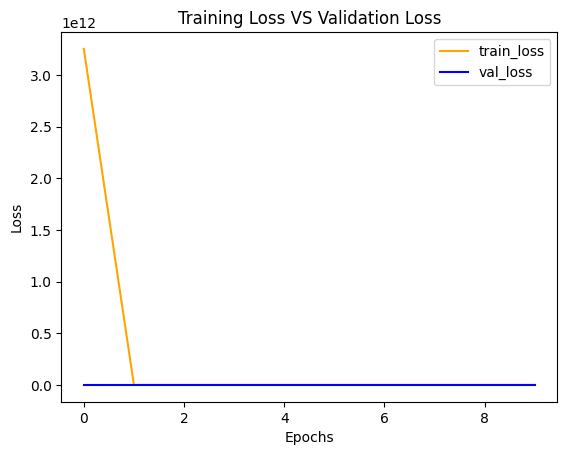

In [25]:
import matplotlib.pyplot as plt
eps = range(NUM_EPOCHS)

fig, ax = plt.subplots(1, 1)

ax.plot(eps, train_loss, c='orange', label = 'train_loss')
ax.plot(eps, val_loss, c='blue', label = 'val_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

**Test**

In [24]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.eval() # Set Network to evaluation mode

with torch.no_grad():
  running_corrects = 0
  for i, (images, labels) in enumerate(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    print(f'Accuracy at batch: {i}: {(1.0*running_corrects/float(len(outputs))):.2f}')

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

Accuracy at batch: 0: 0.85
Accuracy at batch: 1: 1.85
Accuracy at batch: 2: 2.08
Accuracy at batch: 3: 2.08
Accuracy at batch: 4: 2.08
Accuracy at batch: 5: 2.08
Accuracy at batch: 6: 2.08
Accuracy at batch: 7: 2.08
Accuracy at batch: 8: 2.08
Accuracy at batch: 9: 2.08
Accuracy at batch: 10: 2.08
Accuracy at batch: 11: 2.08
Accuracy at batch: 12: 2.08
Accuracy at batch: 13: 2.08
Accuracy at batch: 14: 2.08
Accuracy at batch: 15: 2.08
Accuracy at batch: 16: 2.08
Accuracy at batch: 17: 2.08
Accuracy at batch: 18: 2.08
Accuracy at batch: 19: 2.08
Accuracy at batch: 20: 2.08
Accuracy at batch: 21: 2.08
Accuracy at batch: 22: 2.08
Accuracy at batch: 23: 2.53
Test Accuracy: 0.08724171859626106
